<div class="alert alert-info">
    <font size="5"><b>A/B-тестирование</b></font>

# Table of contents
1. [Часть 1. Вводная информация и декомпозиция](#intro)

2. [Часть 2. Проверка и подготовка данных](#paragraph1)
3. [Часть 3. Анализ данных](#paragraph2)
5. [Часть 4. Гипотезы](#paragraph3)
5. [Часть 5. Выводы](#paragraph5)

## **Вводная информация**<a id="intro"></a>


### Постановка задачи

Задача — провести оценку результатов A/B-теста.

- Оценить корректность проведения теста
- Проанализировать результаты теста

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## **Проверка и подготовка данных**
<a class="anchor" id="paragraph1"></a>

### Загрузка библиотек и датасетов

In [109]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import datetime as dt
from datetime import datetime, timedelta
from scipy import stats as st
import math as mth

In [110]:
events = pd.read_csv('C:/Users/C/project/FINAL_AB/final_ab_events.csv')
marketing = pd.read_csv('C:/Users/C/project/FINAL_AB/ab_project_marketing_events.csv')
new_users = pd.read_csv('C:/Users/C/project/FINAL_AB/final_ab_new_users.csv')
participants = pd.read_csv('C:/Users/C/project/FINAL_AB/final_ab_participants.csv')    

### Проверка данных

In [111]:
display(participants.head(5))
display(participants.info())

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

In [112]:
display(participants.groupby('group').agg({'user_id':'nunique'}))
display(participants.groupby('ab_test').agg({'user_id':'nunique'}))

,user_id
group,
A,9173
B,8269


,user_id
ab_test,
interface_eu_test,11567
recommender_system_test,6701


In [113]:
sys_test = participants[participants['ab_test'] == 'recommender_system_test']
display(sys_test.groupby('group').agg({'user_id':'nunique'}))

,user_id
group,
A,3824
B,2877


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- В нашем тесте есть некоторый перекос в группах, пока что просто отметим это.
- Количество в двух группах дает в сумме общее количество уникальных участников теста, что говорит о том, что нет участников, которые оказались в двух группах сразу.
</div>

In [114]:
# Изучим как были распределены группы во втором исследовании
# Возьмем отдельно людей из группы А и В, посмотрим как они были распределены в interface_eu_test
sys_test_list = sys_test['user_id'].to_list()
sys_test_a_list = sys_test[sys_test['group'] == 'A']['user_id'].to_list()
sys_test_b_list = sys_test[sys_test['group'] == 'B']['user_id'].to_list()

print('Для группы А')
interface_test = participants[participants['ab_test'] == 'interface_eu_test']
display(interface_test.query('user_id in @sys_test_a_list').groupby('group').agg({'user_id':'nunique'}))
print('\nДля группы B')
display(interface_test.query('user_id in @sys_test_b_list').groupby('group').agg({'user_id':'nunique'}))

Для группы А


,user_id
group,
A,482
B,439



Для группы B


,user_id
group,
A,337
B,344


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Распределение достаточно равномерное, что означает, что, даже если существует влияние второго теста на тот, с которым мы работаем, оно будет одинаково для обеих групп. В таком случае нет оснований исключать пользователей, которые участвовали в обоих тестах.
- На данном этапе количество участников выше 6000, что удовлетворяет ТЗ.
</div>

In [115]:
# Убираю из датафрейма участников второго теста
events_full = events
events = events.query('user_id in @sys_test_list')

In [116]:
display(events.head())
display(events.info())

,user_id,event_dt,event_name,details
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99
74,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24698 entries, 5 to 440289
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     24698 non-null  object 
 1   event_dt    24698 non-null  object 
 2   event_name  24698 non-null  object 
 3   details     3331 non-null   float64
dtypes: float64(1), object(3)
memory usage: 964.8+ KB


None

In [117]:
# Перевожу дату в datetime
events['event_dt'] = pd.to_datetime(events['event_dt'])

In [118]:
# Проверка на дубликаты
events.groupby('event_name').agg({'user_id' : 'nunique'})

,user_id
event_name,
login,3675
product_cart,1079
product_page,2303
purchase,1128


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Воронка есть, но количество уникальных пользователей, совершивших действие, очень мало. На это стоит обратить внимание.
</div>

In [119]:
events['event_dt'].min()

Timestamp('2020-12-07 00:05:57')

In [120]:
events['event_dt'].max()

Timestamp('2020-12-30 12:42:57')

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Даты входят в рамки, указанные в ТЗ, но нет данных за последние 5 дней. Это надо будет учесть в дальнейшем.
</div>

In [121]:
# Проверка на дубликаты в event_dt
display(events[events.event_dt.duplicated(keep=False)].count())

user_id       14534
event_dt      14534
event_name    14534
details        3321
dtype: int64

In [122]:
display(events[events.event_dt.duplicated(keep=False)].sort_values(by='event_dt').head(20))

,user_id,event_dt,event_name,details
252955,894A2506B3A50D03,2020-12-07 00:05:57,login,NaN
126644,894A2506B3A50D03,2020-12-07 00:05:57,product_page,NaN
713,8FC9D1BB3017BE66,2020-12-07 00:07:47,purchase,4.99
252916,8FC9D1BB3017BE66,2020-12-07 00:07:47,login,NaN
1221,4A55475E078F40DC,2020-12-07 00:14:01,purchase,9.99
254351,4A55475E078F40DC,2020-12-07 00:14:01,login,NaN
127162,20996AEF74602821,2020-12-07 00:16:00,product_page,NaN
253729,20996AEF74602821,2020-12-07 00:16:00,login,NaN
993,20996AEF74602821,2020-12-07 00:16:00,purchase,9.99
255395,115EBC1CA027854A,2020-12-07 00:25:02,login,NaN


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Есть большое число дубликатов, явно не являющихся совпадениями. Это выглядит как ошибка в момент записи логов или в какой-то другой этап работы с данными. Согласно этим данным, пользователи могут совершать от 2 до 4 действий одновременно.
</div>

In [123]:
# Убедимся, что NaN в details относятся только к действиям, которые не являются покупкой
display(events[events['event_name']=='purchase']['details'].isna().value_counts())

False    3331
Name: details, dtype: int64

count    3331.000000
mean       23.212756
std        70.848522
min         4.990000
25%         4.990000
50%         4.990000
75%         9.990000
max       499.990000
Name: details, dtype: float64

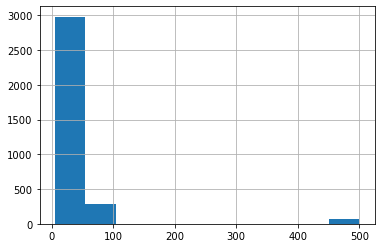

In [124]:
# Проверка details на выбросы и аномалии.
display(events['details'].describe())
events['details'].hist()
plt.show()

In [125]:
# 500 выглядит как выброс, посмотрим сколько таких значений
len(events[events['details'] ==  499.990000])

62

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Есть 62/3331 значений 500, это около 2%, судя по всему это реальные данные, не ошибка, но это стоит отметить.
</div>

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

Выводы по events:

- Пропусков нет, кроме цены у действий, которые не являются покупкой, что нормально.
- Даты не до конца совпадают с тз, нет данных за последние 5 дней.
- Судя по количеству действий, корзина не является обязательным действием для покупки.
- Есть большое количество дубликатов вызваных, скорее всего, технической ошибкой. На это мы не можем повлиять, поэтому работаем с этими данными, но это обязательно должно быть отмечено в отчете.  
</div>

In [126]:
display(marketing)
display(marketing.info())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

In [127]:
# Перевожу дату в datetime
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])

In [128]:
# Добавляю, чтобы увидеть продолжительность промо
marketing['delta'] = marketing['finish_dt'] - marketing['start_dt']

In [129]:
marketing = marketing[marketing['finish_dt'] >= '2020-12-07']

In [130]:
display(marketing)

,name,regions,start_dt,finish_dt,delta
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,9 days
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07,8 days


In [131]:
#дата запуска: 2020-12-07
#дата остановки набора новых пользователей: 2020-12-21

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Данные выглядят нормально. На данном этапе возникает выбор, либо урезать количество участников теста до тех, кто зарегистрировался до 2020-12-10 и ограничить тест 2020-12-24 (так, чтобы не было наслоения на Рождественское промо). Либо, можно взять всю имеющуюся дистанцию теста, ограничив зарегистрированными до 16, что дает нам 6 дней новых пользователей. Для принятия решения стоит изучить сколько мы потеряем, отбросив всех после 2020-12-10. Сделаю это после обработки оставшихся датасетов.
</div>


In [132]:
new_users = new_users.query('user_id in @sys_test_list')
display(new_users.head(5))
display(new_users.info())

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
13,E6DE857AFBDC6102,2020-12-07,EU,PC
20,DD4352CDCF8C3D57,2020-12-07,EU,Android
23,831887FE7F2D6CBA,2020-12-07,EU,Android
39,4CB179C7F847320B,2020-12-07,EU,iPhone


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6701 entries, 0 to 61715
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6701 non-null   object
 1   first_date  6701 non-null   object
 2   region      6701 non-null   object
 3   device      6701 non-null   object
dtypes: object(4)
memory usage: 261.8+ KB


None

In [133]:
# Перевожу дату в datetime
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
display(new_users['first_date'].min())
display(new_users['first_date'].max())

Timestamp('2020-12-07 00:00:00')

Timestamp('2020-12-21 00:00:00')

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Дата запуска: 2020-12-07; дата остановки набора новых пользователей: 2020-12-21; Все совпадает с ТЗ.
- Позже данные придется сократить, либо до 2020-12-10, либо до 2020-12-16.
</div>

In [134]:
display(new_users.groupby('region').agg({'user_id':'nunique'}))
display(new_users.groupby('device').agg({'user_id':'nunique'}))

,user_id
region,
APAC,72
CIS,55
EU,6351
N.America,223


,user_id
device,
Android,2983
Mac,633
PC,1707
iPhone,1378


In [135]:
# Убираю пользователей не из EU. Представителей других регионов около 2% всей выборки, при этом в ТЗ указано, что аудитория - 
# - только жители EU. Таким образом следуем ТЗ более строго не теряя большого числа участников.
new_users = new_users[new_users['region'] == 'EU']
sys_test_list = new_users['user_id'].to_list()

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Убрал 350 пользователей из оставшихся регионов. В остальном датасет в порядке.
</div>

In [136]:
# Узнаем сколько пользователей из EU добавилось после 2020-12-07 
total_users = len(events_full['user_id'].unique())
new_users_from_EU = len(new_users)
print(f'Доля привлеченных пользователей из EU: {(new_users_from_EU / total_users):.2%}', )

Доля привлеченных пользователей из EU: 10.82%


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

<b> Общие замечания по проверке данных </b>
    
- На данный момент имеется 6351 пользователей до фильтрации по датам. Скорее всего число участников станет ниже 6000, указанных в ТЗ. Задача - постараться сохранить больше пользователей без значительных искажений данных, чтобы не сильно отходить от ТЗ.
- Нет оснований считать, что другой тест значительно повлияет на наше исследование. Также нет дублирующихся участников в двух группах. Однако, есть перевес в количестве в одной из групп, примерно в 30%. Разница весомая, стоит обратится к этим данным после фильтрации по датам. Если разница не увеличится значительно, то мы сохраняем пользователей, так как, в первую очередь, сравниваем относительные показатели, а не абсолютные.
- Необходимо изучить количество участников, если откинуть новогоднее промо. Принять решение, стоит ли этих участников убирать.
- Последняя дата в датасете на 5 меньше указанной в ТЗ.
- Привлечено почти 11% Европейцев. Это недостаточно для удовлетворения ТЗ, но не слишком мало.
</div>

### Подготовка данных

In [137]:
# Сравним 2 выборки, те кто имел лайфтайм 14 дней к 2020-12-24 и к 2020-12-30
print('Регистрация до 10 числа', len(new_users[new_users['first_date'] <= '2020-12-10']))
print('Регистрация до 16 числа', len(new_users[new_users['first_date'] <= '2020-12-16']))

Регистрация до 10 числа 1561
Регистрация до 16 числа 4086


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Не учитывать тех, кто попадает на новогодние промо не оправдано, так как они составляют больше половины имеющихся участников.
- Также важно отметить, что датасет содержит чуть больше 4 тысяч человек, что уже ниже указанных в ТЗ 6000.
</div>

In [138]:
# Последняя дата регистрации для нашего исследования = 2020-12-16
new_users = new_users[new_users['first_date'] <= '2020-12-17']

In [139]:
events

,user_id,event_dt,event_name,details
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99
74,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99
...,...,...,...,...
440239,D21F0D4FDCD82DB2,2020-12-29 02:17:00,login,NaN
440258,96BDD55846D1F7F6,2020-12-29 16:53:42,login,NaN
440267,553BAE96C6EB6240,2020-12-29 14:09:14,login,NaN
440281,DD4352CDCF8C3D57,2020-12-30 12:42:56,login,NaN


In [140]:
new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
13,E6DE857AFBDC6102,2020-12-07,EU,PC
20,DD4352CDCF8C3D57,2020-12-07,EU,Android
23,831887FE7F2D6CBA,2020-12-07,EU,Android
39,4CB179C7F847320B,2020-12-07,EU,iPhone
...,...,...,...,...
57416,CB194C10D84C7E25,2020-12-13,EU,PC
57432,2816B43B4A070B95,2020-12-13,EU,Android
57433,AD21E668FC949228,2020-12-13,EU,Mac
57441,1FCFF602844AD352,2020-12-13,EU,Android


In [141]:
# Сокращаю остальные датафреймы под это условие
new_users_list = new_users["user_id"].to_list()
events = events.query('user_id in @new_users_list') 

In [142]:
# Убираю колонку с тестом, так как он всего один
sys_test = sys_test.drop(['ab_test'], axis=1)

In [143]:
sys_test.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
A,3824
B,2877


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Разница между группами около 30%, но при этом она стала меньше в абсолютных значениях.
</div>

In [144]:
events.groupby('event_name').agg({'user_id' : 'nunique'})

,user_id
event_name,
login,2155
product_cart,645
product_page,1327
purchase,645


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
   
- В воронке все еще значительно меньшей действий, чем участников, почти в 2 раза. Узнаем, как выглядит распределение на A и B после того, как мы оставим только активных юзеров.
- Это значительная потеря в мощности теста, но мы не можем на это повлиять. Поскольку для нас важно узнать разницу в конверсии разных групп, пользователи не сделавшие действий не дают нам этих данных. Они могут быть здесь по 2 причинам. Либо логин не равен основной странице, и эти пользователи, например, заходили на главную и покидали сайт. Либо, данные этих пользователей некорректно занесло в логи и мы потеряли информацию об их действиях. В любом случае придется их отбросить.
</div>

In [145]:
# Формирую список тех id, с которыми будем работать
id_list = set(events['user_id'].to_list())
len(id_list)

2155

In [146]:
sys_test = sys_test.query('user_id in @id_list')
new_users = new_users.query('user_id in @id_list')

In [147]:
sys_test.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
A,1515
B,640


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
 
- Данные отсортированы и готовы к исследовательскому анализу.
- По итогам обработки данных стоит отметить большое количество недочетов, ошибок в данных и расхождений с ТЗ:
    - 1) Невозможность сделать выборку более 6000 по ряду причин.
    - 2) После вычета пользователей без действий остается 3675 пользователей, что уже почти в 2 раза ниже указанных в ТЗ.
    - 3) В ТЗ говорится, что тест проведен до 2021-01-04, однако данные даны только до 2020-12-30, что сокращает количество пользователей с лайфтаймом в 14 дней и влияет на результаты исследования.
    - 4) Привлечено было около 11% Европейцев, что несколько ниже заявленных в ТЗ 15%.
    - 5) Количество пользователей в группе А превышает количество пользователей группы более чем в 2 раза, что тоже может сказаться на результатах исследования и говорит о неправильном распределении тестовых групп.
    - 6) Чтобы не терять еще больше пользователей, в выборку попадают те, кто застал новогоднее промо. Это не критично, но важно это отметить и помнить во время исследования.
- Таким образом, после обработки данных, из более чем 6000 участников остается 1917. Все вышеперечисленное вместе может значительно исказить результаты исследования. Те данные, которые остались после очистки, более валидны, хоть мы и потеряли более 60% пользователей и идем в разрез с ТЗ.
</div>

## **Исследовательский анализ данных**
<a class="anchor" id="paragraph2"></a>

In [148]:
# Соберем все данные в один датасет для удобства работы
new_users = new_users.merge(sys_test, on='user_id', how='left')
events = events.merge(new_users, on='user_id', how='outer')
events = events.drop(['region'], axis=1)

In [149]:
# Убираем пользователей с лайфтаймом выше 14 дней
events['date'] = pd.to_datetime(events['event_dt'].dt.date)
events['delta'] = (events['date'] - events['first_date'])
events = events[events['delta'] <= pd.Timedelta('14 days')]

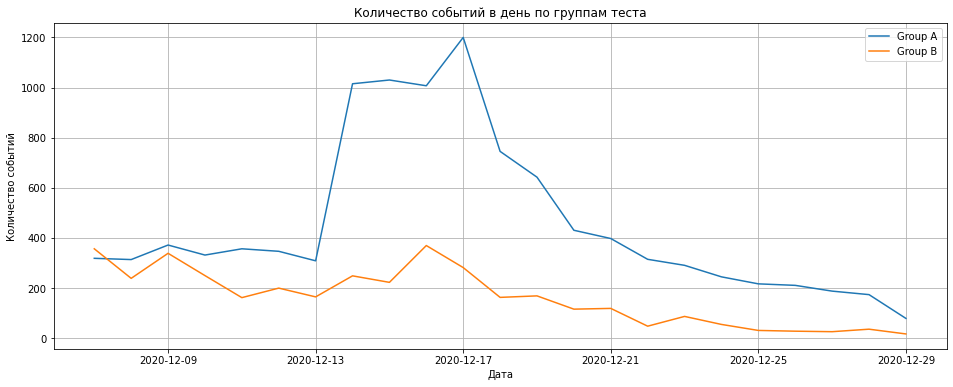

In [150]:
# Как число событий в выборках распределено по дням?
temp_events = events.groupby(['group','date']).agg({'user_id':'count'}).reset_index()
# задаем размер графика:
plt.figure(figsize=(16, 6))

# тут мы посмтроим два графика:
plt.plot(temp_events.query('group == "A"')['date'], temp_events.query('group == "A"')['user_id'], label = "Group A")
plt.plot(temp_events.query('group == "B"')['date'], temp_events.query('group == "B"')['user_id'], label = "Group B")

# зададим корректное оформление:
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Количество событий в день по группам теста')

plt.legend()
plt.grid()
plt.show()

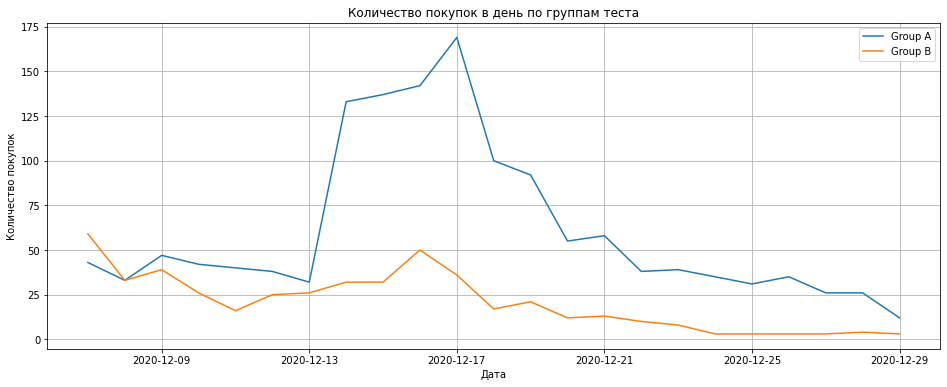

In [151]:
# Как число покупок в выборках распределено по дням?
purchase = events[events['event_name'] == 'purchase']
# группируем данные для графика:
temp_purchase = purchase.groupby(['group','date']).agg({'user_id':'count'}).reset_index()

# задаем размер графика:
plt.figure(figsize=(16, 6))

# тут мы посмтроим два графика:
plt.plot(temp_purchase.query('group == "A"')['date'], temp_purchase.query('group == "A"')['user_id'], label = "Group A")
plt.plot(temp_purchase.query('group == "B"')['date'], temp_purchase.query('group == "B"')['user_id'], label = "Group B")

# зададим корректное оформление:
plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.title('Количество покупок в день по группам теста')

plt.legend()
plt.grid()
plt.show()

In [152]:
events_timed = events[(events['date'] >= '2020-12-13') & (events['date'] <= '2020-12-17')]
print('Количество событий с 13.12 по 17.12 =', len(events_timed))

Количество событий с 13.12 по 17.12 = 5844


In [153]:
print('Количество дублированных событий с 13.12 по 17.12 =', len(events_timed[events_timed.event_dt.duplicated(keep=False)]))

Количество дублированных событий с 13.12 по 17.12 = 3452


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Распределение как покупок, так и действий в целом по дням достаточно равномерное, с тенденцией на снижение, за исключением одного длительного всплеска в группе В. Я связываю это с дубликатами, которые возникли еще на стадии подготовки данных, скорее всего произошла ошибка в логах и зарегистрировала больше действий, чем на самом деле их было предпринято.
- Наблюдается довольно стабильный спад, начиная с 21.12. Судя по графику, промо 25 числа практически не оказало влияния.
</div>

In [154]:
# Количество событий на пользователя одинаково распределены в выборках?
events_grouped = (
    events.groupby(['user_id', 'group'])
    .agg({'event_name':'count'})
    .rename(columns={'event_name' : 'count'})
    .reset_index()
)

In [155]:
# Посмотрим на показатели describe для каждой группы
print('Группа А')
display(events_grouped[events_grouped['group'] == 'A'].describe())

Группа А


,count
count,1515.000000
mean,6.944554
std,3.865245
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,24.000000


In [156]:
print('Группа B')
display(events_grouped[events_grouped['group'] == 'B'].describe())

Группа B


,count
count,640.000000
mean,5.793750
std,3.464728
min,1.000000
25%,3.000000
50%,6.000000
75%,8.000000
max,24.000000


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Все действия выглядят приемлемо, медианы совпадают, максимум тоже, количество максимальных действий реалистично. Несоколько отличаются средние показатели.
</div>

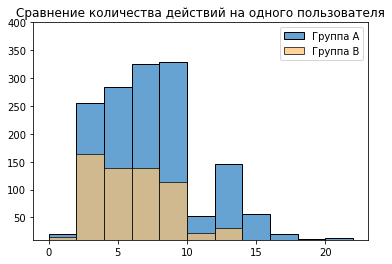

In [157]:
#price_spb_centr
x = events_grouped[events_grouped['group'] == 'A']['count']
y = events_grouped[events_grouped['group'] == 'B']['count']       
bins = np.linspace(0, 22, 12)
plt.title('Сравнение количества действий на одного пользователя')
plt.ylim([10, 400])
plt.hist(x, bins, alpha=1, color="#66A3D2", edgecolor='k', label='Группа А')
plt.hist(y, bins, alpha=0.7, color="#FFC373", edgecolor='k', label='Группа B')
plt.legend(loc='upper right')
plt.show()

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
  
- Благодаря графику мы увидели, что в группе А значительно больше пользователей делали более 10 действий. Речь не только об абсолютных показателях, но и об относительных, которые для нас наиболее важны. Также среди меньших действий на человека, лидирует тоже группа А, но уже не так ощутимо.
</div>

In [158]:
# Создаем датасеты для воронок
# Датасет для группы А
funnel_a = (
    events[events['group'] == 'A']
    .groupby('event_name')
    .agg({'user_id':'nunique'})
    .rename(columns={'user_id':'count'})
    .reindex(['login', 'product_page', 'product_cart', 'purchase'])
    .reset_index()
)

# Поскольку переход в корзину необязателен, то конверсию считаю от первого действия, а не от предыдущего
funnel_a['conversion'] = (
    funnel_a['count'] / funnel_a['count'][0]
    ).apply(lambda x: '{0:1.3}'.format(x))

# Переименовываю для лучшей визуализации воронки
funnel_a['event_name'] = funnel_a['event_name'].replace(
    {'login' : 'Логин',
     'product_page' : 'Предложения',
     'product_cart' : 'Корзина', 
     'purchase' : 'Оплата'   
})


funnel_a['group'] = 'A'

In [159]:
# Создаем датасеты для воронок
# Датасет для группы А
funnel_b = (
    events[events['group'] == 'B']
    .groupby('event_name')
    .agg({'user_id':'nunique'})
    .rename(columns={'user_id':'count'})
    .reindex(['login', 'product_page', 'product_cart', 'purchase'])
    .reset_index()
)

# Поскольку переход в корзину необязателен, то конверсию считаю от первого действия, а не от предыдущего
funnel_b['conversion'] = (
    funnel_b['count'] / funnel_b['count'][0]
    ).apply(lambda x: '{0:1.3}'.format(x))

# Переименовываю для лучшей визуализации воронки
funnel_b['event_name'] = funnel_b['event_name'].replace(
    {'login' : 'Логин',
     'product_page' : 'Предложения',
     'product_cart' : 'Корзина', 
     'purchase' : 'Оплата'
})

funnel_b['group'] = 'B'

In [160]:
# Создаю воронку событий с % конверсии от первого шага на обе группы
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А',
    y = funnel_a['event_name'],
    x = funnel_a['count'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Группа B',
    y = funnel_b['event_name'],
    x = funnel_b['count'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(
    title={
        'text': "Воронка событий",
        'y':0.88,
        'x':0.49,
        'xanchor': 'center',
        'yanchor': 'top'}
)
fig.show()


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
 
- К сожалению, конверсия на каждом этапе ухудшилась или осталось той же.
- Переход от регистрации/логина к предложениям - снижение на 6 процентных пунктов, это плохой показатель. Это было бы не так страшно, если бы были улучшения конверсии на других этапах, но они опустились на 1 процентный пункт. В итоге единственный положительный результат у группы В - конверсия из Предложения в Корзину, около 3.5 процентных пункта. 
- Нам это говорит о том, что изменения для группы В на данном этапе не имеют применения и от них стоит отказаться.
</div>

In [161]:
# Создаю отдельную воронку, чтобы узнать потерю конверсии в процентах
relative_funnel = funnel_a.drop(['count','group'], axis=1).rename(columns={'conversion':'conversion_a'})
relative_funnel['conversion_a'] = relative_funnel['conversion_a'].astype(float)
relative_funnel['conversion_b'] = funnel_b['conversion'].astype(float)

In [162]:
relative_funnel['relative'] = (
    (relative_funnel['conversion_b'] / relative_funnel['conversion_a'] - 1)
    .apply(lambda x: '{0:1.2%}'.format(x))
)

In [163]:
display(relative_funnel)

,event_name,conversion_a,conversion_b,relative
0,Логин,1.000,1.000,0.00%
1,Предложения,0.635,0.571,-10.08%
2,Корзина,0.302,0.293,-2.98%
3,Оплата,0.305,0.286,-6.23%


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">
 
- Потеря конверсии в 10% на первом этапе, на этапе предложения, это очень плохой результат и он возможно не был бы катострафичным, если бы был значительный рост в оплате, как я и писал раньше. Проблема в том, что на оплате потеряно 6%, что тоже значительный показатель.
</div>

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

<i>Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?</i>
    
    
- Помимо тех, что на которых я акцентировал внимание во время проверки и подготовки данных, добавился всплеск активности у группы В на несколько дней, без значительного роста у группы А. С высокой долей вероятности, это объясняется технической ошибкой и может оказать влияние на результат теста.
</div>

## **Проверка статистической разницы**
<a class="anchor" id="paragraph3"></a>

In [164]:
# Функия для проверки статистически важной разницы между группами
def stat_diff(stepA, stepB, groupA, groupB):
    alpha = 0.05 

    step = np.array([stepA, stepB])
    leads = np.array([groupA, groupB])

    p1 = step[0]/leads[0]
    p2 = step[1]/leads[1]
    difference = p1 - p2
    p_combined = ((step[0] + step[1]) / (leads[0] + leads[1]))

    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / leads[0] + 1 / leads[1])
    )

    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if p_value < alpha: 
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [165]:
a_total = funnel_a['count'].sum()
b_total = funnel_b['count'].sum()

In [166]:
stat_diff(funnel_a['count'][1], funnel_b['count'][1], a_total, b_total)

p-value:  0.2207301916369948
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [167]:
stat_diff(funnel_a['count'][2], funnel_b['count'][2], a_total, b_total)

p-value:  0.9072156494559322
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [168]:
stat_diff(funnel_a['count'][3], funnel_b['count'][3], a_total, b_total)

p-value:  0.7968211576512199
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- Во всех трех этапах конверсии нет оснований считать доли разными, что дает возможность подвести итоги и сделать выводы о проделанном исследовании.
</div>

## **Общие выводы**
<a class="anchor" id="paragraph5"></a>

<div class="alert alert-info" style="background:rgba(135, 206, 235, 0.05);color:#080808">

- В данном исследовании было много ошибок в генерации логов и в формировании ТЗ. По этой причине некоторые решения принятые в процессе подготовки даннных могут быть спорными. На мой взгляд проведение такого AB-теста некорректно и является тратой ресурсов компании. Помимо этого потеря времени на проведение теста и потеря продаж, но это естественные элементы АВ-тестов, которые, на мой взгляд, должны закладываться в него.
- Данные были сформированны некорректно: отсутствуют записи о действиях более 2500 тыс, отсутствуют 5 последних дней исследования, деление на группы с разницей в 30%. В купе это сильно искажает получаемые результаты, и если бы конечный результат не был бы однозначным (например приросто конверсии на 2%), то было бы трудно сделать вывод о результатах теста, так как, на более качественной выборке это может быть 6% дохода или 2% расхода.
- В нашем случае вывод довольно однозначный, группа В не является прибыльной, а скорее всего, убыточной. Насколько убыточной, оценить трудно, в силу имеющихся данных, потери конверсии в продажи составили около 10%. Этого достаточно, чтобы отказаться от использования изменений, введенных для этой группы.
</div>